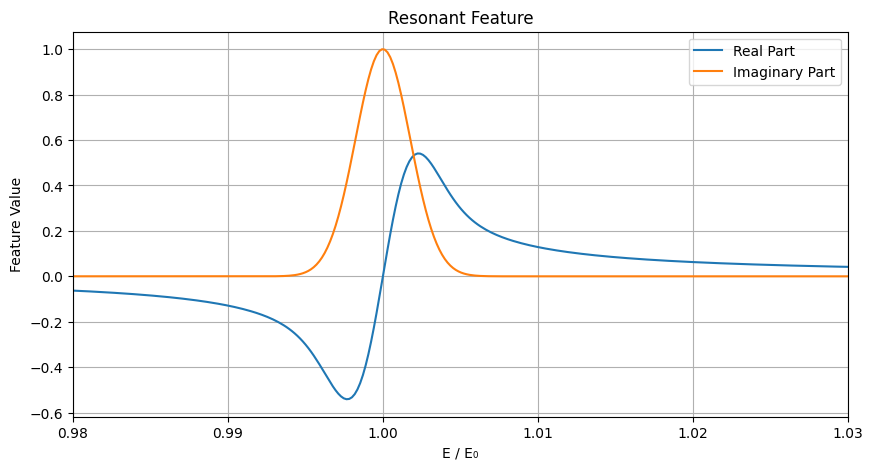

In [2]:
import numpy as np
from scipy.special import dawsn
import matplotlib.pyplot as plt


def resonant_feature(energy, resonance, width, amplitude=1.0) -> np.ndarray:
    """
    Functional form of a resonant feature with gaussian-like dispersion.

    The imaginary part of the feature is modeled as a gaussian shape function,
    centered at a resonance energy, with a specified width. The real part is
    then the dawson function defined though the dawson integral.

    P(E, R, W, A) = A * (dawson((E - R) / W) + i * exp(-(E - R)^2 / (2 * W^2)))

    Parameters:
    -----------
    energy : float or np.ndarray
        Energy at which to evaluate the feature.
    resonance : float
        Resonance energy.
    width : float
        Width of the resonance.
    amplitude : float, optional
        Amplitude of the resonance, default is 1.0.

    Returns:
    --------
    np.ndarray
        The value of the resonant feature at the specified energy.
    """
    if isinstance(energy, (int, float)):
        energy = np.array([energy])

    # Calculate the imaginary part
    imag_part = amplitude * np.exp(-1 / 2 * ((energy - resonance) / width) ** 2)
    real_part = 1 * amplitude * dawsn(1 / np.sqrt(2) * (energy - resonance) / width)

    # Combine real and imaginary parts
    return real_part + 1j * imag_part


#  plot this
energy = np.linspace(250, 300, 1000)
resonance = 284
width = 0.5
amplitude = 1
feature = resonant_feature(energy, resonance, width, amplitude)
plt.figure(figsize=(10, 5))
plt.plot(energy / resonance, feature.real, label="Real Part")
plt.plot(energy / resonance, feature.imag, label="Imaginary Part")
plt.title("Resonant Feature")
plt.xlabel("E / E₀")
plt.xlim(0.98, 1.03)
plt.ylabel("Feature Value")
plt.legend()
plt.grid()
plt.show()


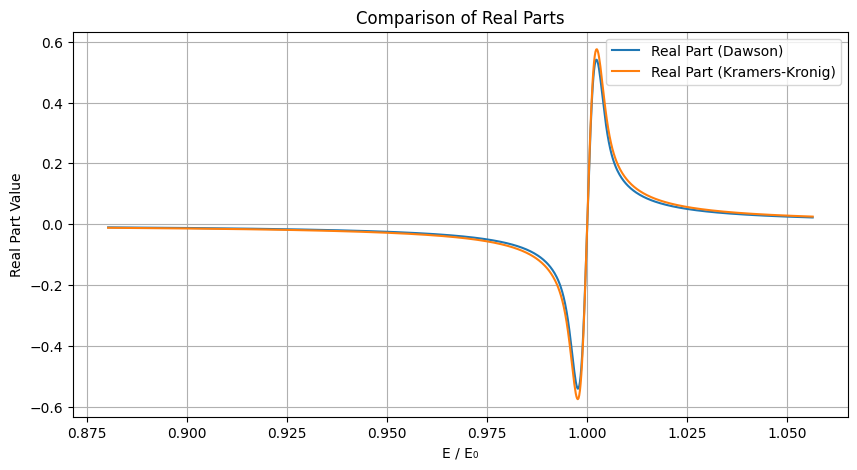

In [3]:
def imag_to_real(peak: np.ndarray, energy: np.ndarray) -> np.ndarray:
    """
    Convert the imaginary part of a resonant feature to its real part.


        This function uses the kramers-kronig relation to compute the real part
    of the resonant response from the imaginary part for a series of energies.

    Parameters:
    -----------
    peak : float
        The peak value of the imaginary part.
    energy : float or np.ndarray
        Energy at which to evaluate the real part.

    Returns:
    --------
    np.ndarray
        The real part of the resonant feature at the specified energy.
    """
    # Use the trapz method to compute the integral
    real_part = np.zeros_like(energy, dtype=np.float64)
    for i, e in enumerate(energy):
        #  for the principal value integral, we need to avoid division by zero
        if i == 0:
            integral = np.trapezoid(peak[1:] / (e - energy[1:]), energy[1:])
        elif i == len(energy) - 1:
            integral = np.trapezoid(
                peak[:i] / (e - energy[:i]), energy[:i]
            ) + np.trapezoid(peak[i + 1 :] / (e - energy[i + 1 :]), energy[i + 1 :])
        else:
            integral = np.trapezoid(
                peak[:i] / (e - energy[:i]), energy[:i]
            ) + np.trapezoid(peak[i + 1 :] / (e - energy[i + 1 :]), energy[i + 1 :])
        real_part[i] = 1 / np.pi * integral
    return real_part


# Compare the results
kk_real_part = imag_to_real(feature.imag, energy)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(energy / resonance, feature.real, label="Real Part (Dawson)")
ax.plot(energy / resonance, kk_real_part, label="Real Part (Kramers-Kronig)")
ax.set_title("Comparison of Real Parts")
ax.set_xlabel("E / E₀")
ax.set_ylabel("Real Part Value")
ax.legend()
ax.grid()
plt.show()

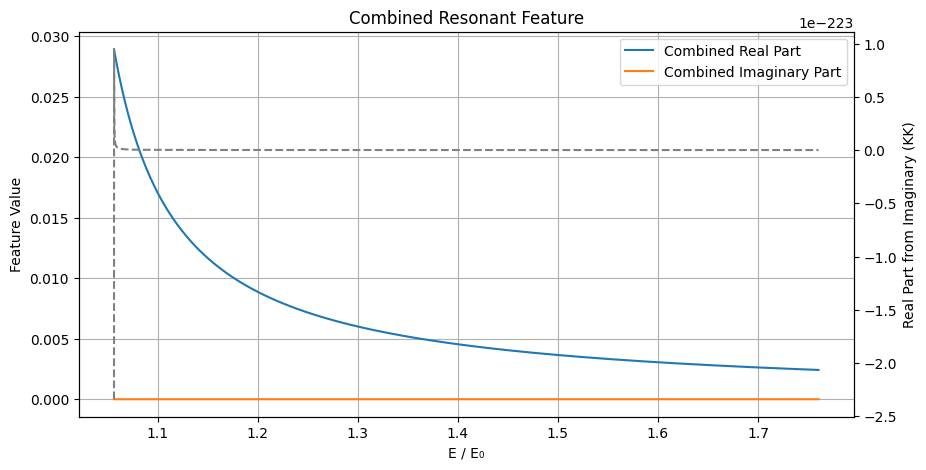

In [4]:
#  Now for two peaks summed together

extended_energy = np.linspace(300, 500, 100000)

feature1 = resonant_feature(extended_energy, resonance, width, amplitude)
feature2 = resonant_feature(extended_energy, resonance - 10, width, amplitude / 2)
combined_feature = feature1 + feature2

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(extended_energy / resonance, combined_feature.real, label="Combined Real Part")
ax.plot(
    extended_energy / resonance, combined_feature.imag, label="Combined Imaginary Part"
)
ax.set_title("Combined Resonant Feature")
ax.set_xlabel("E / E₀")
ax.set_ylabel("Feature Value")

twin_ax = ax.twinx()
twin_ax.plot(
    extended_energy / resonance,
    imag_to_real(combined_feature.imag, extended_energy),
    label="Real Part from Imaginary (KK)",
    linestyle="--",
    color="gray",
)
twin_ax.set_ylabel("Real Part from Imaginary (KK)")

ax.legend()
ax.grid()

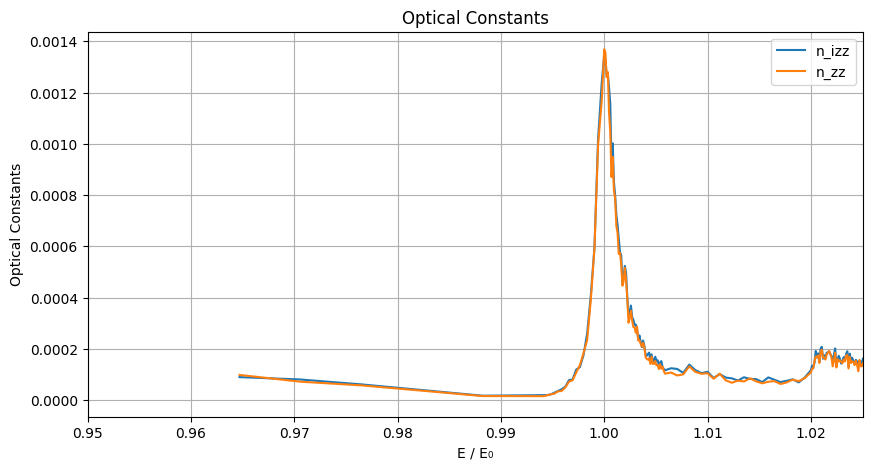

In [5]:
import pandas as pd

#  Now let's load in a sample optical model and plot it, this will be fit later on
df = pd.read_csv("Ni_grating_86456.csv")

df["energy"] = df["energy_list"]
df["n_izz"] = df["-2.0"] * 1e-9
df["n_zz"] = df["2.0"] * 1e-9
ip = 850
# df = pd.read_csv("optical_constants.csv")
#  Slice to 250 - 300 eV
# df = df[(df["energy"] >= 250) & (df["energy"] <= 300)]
df["e/ip"] = df["energy"] / ip
df.plot(x="e/ip", y=["n_izz", "n_zz"], figsize=(10, 5))
plt.title("Optical Constants")
plt.xlabel("E / E₀")
plt.ylabel("Optical Constants")
plt.xlim(0.95, 1.025)
plt.grid()

In [6]:
from periodictable import xsf
import periodictable as pt

carbon_ionization = 850
#  Determine the energy shift to place the ionization energy at the ip value
ionization_shift = ip - carbon_ionization
n = xsf.index_of_refraction(
    "Ni", density=1, energy=(df["energy"] - ionization_shift) * 1e-3
)
n_i = -n.imag
n_r = 1 - n.real

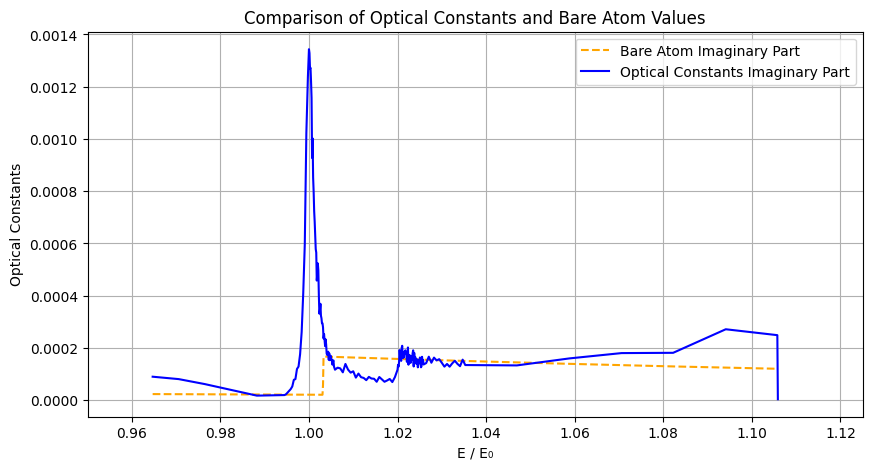

In [7]:
#  plot the bare atom values and the optical constants
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    df["e/ip"], n_i, label="Bare Atom Imaginary Part", linestyle="--", color="orange"
)
# ax.plot(df["e/ip"], n_r, label="Bare Atom Real Part", linestyle="--", color="green")
ax.plot(df["e/ip"], df["n_izz"], label="Optical Constants Imaginary Part", color="blue")
# ax.plot(df["e/ip"], df["n_zz"], label="Optical Constants Real Part", color="red")
ax.set_title("Comparison of Optical Constants and Bare Atom Values")
ax.set_xlabel("E / E₀")
ax.set_ylabel("Optical Constants")
ax.legend()
ax.set_xlim(0.95, 1.125)
ax.grid()
plt.show()

Found 3 peaks in the imaginary part of the optical constants at energies: [np.float64(847.1), np.float64(850.0), np.float64(852.0)]


/tmp/ipykernel_267536/4286550132.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["n_izz"] -= df["n_izz"].iloc[0]


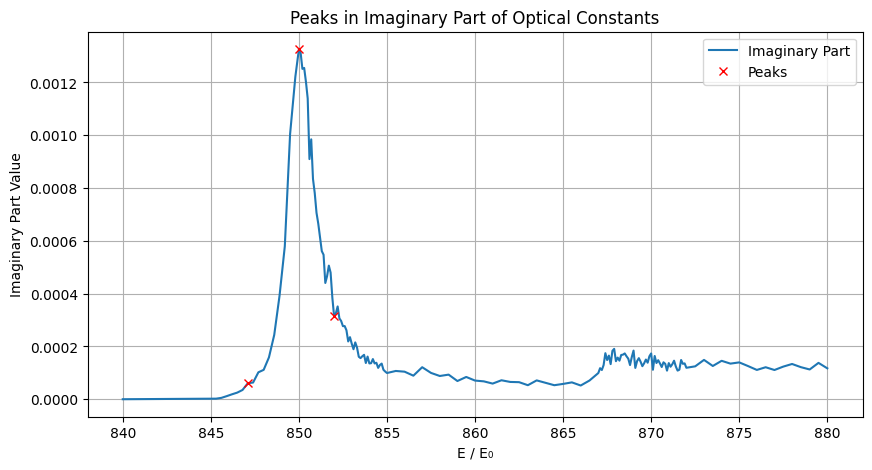

In [8]:
# Use scipy signal to find the peaks in the imaginary part
from scipy.signal import find_peaks

mask = (df["energy"] >= 840) & (df["energy"] <= 885)
n_i = n_i[np.where(df["energy"].values[mask])]
n_r = n_r[np.where(df["energy"].values[mask])]
df = df[mask]
#  Scale the df so that at zero it is 0
df["n_izz"] -= df["n_izz"].iloc[0]
peaks, _ = find_peaks(df["n_izz"], height=np.max(n_i))
peaks = [df["energy"][p] for p in peaks]
# Find the closest energy value in the dataframe for each manually specified peak
manual_peaks = [847, 850, 852]
peaks = [
    df["energy"].iloc[np.abs(df["energy"].values - p).argmin()] for p in manual_peaks
]
print(
    f"Found {len(peaks)} peaks in the imaginary part of the optical constants at energies: {peaks}"
)
#  Plot the peaks on the imaginary part
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["energy"], df["n_izz"], label="Imaginary Part")
ax.plot(peaks, df["n_izz"][df["energy"].isin(peaks)], "x", label="Peaks", color="red")
ax.set_title("Peaks in Imaginary Part of Optical Constants")
ax.set_xlabel("E / E₀")
ax.set_ylabel("Imaginary Part Value")
ax.legend()
ax.grid()

Peak 3: Center=848.08 eV, Width=0.863 eV, Amplitude=0.0001
Peak 4: Center=849.99 eV, Width=0.667 eV, Amplitude=0.0011
Peak 5: Center=851.61 eV, Width=1.000 eV, Amplitude=0.0003


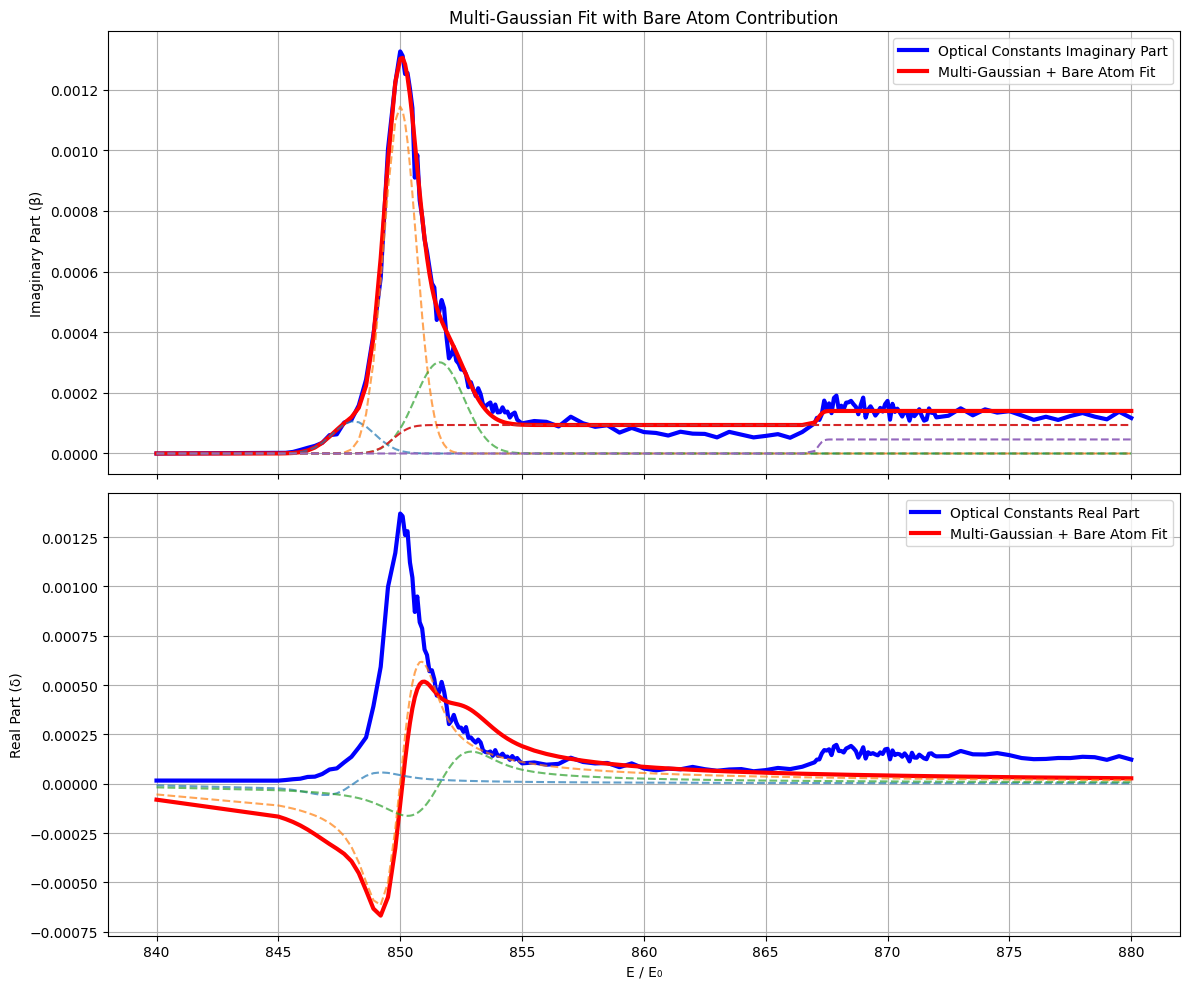

R-squared: 0.9914


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import numpy as np
from scipy.special import erf


def multi_gaussian_with_bare_atom(energy, *params):
    """
    Model function for multiple Gaussian peaks plus bare atom contribution modeled by two error functions.
    params should be:
    [erf1_center, erf1_width, erf1_amp, erf2_center, erf2_width, erf2_amp,
     center1, width1, amp1, center2, width2, amp2, ...]
    """
    # Extract error function parameters
    erf1_center = params[0]
    erf1_width = params[1]
    erf1_amp = params[2]
    erf2_center = params[3]
    erf2_width = params[4]
    erf2_amp = params[5]

    # Bare atom contribution modeled by two error functions
    erf1 = erf((energy - erf1_center) / erf1_width)
    erf2 = erf((energy - erf2_center) / erf2_width)
    result = erf1_amp * (1 + erf1) / 2 + erf2_amp * (1 + erf2) / 2

    # Remaining parameters are for Gaussian peaks
    peak_params = params[6:]
    n_peaks = len(peak_params) // 3

    for i in range(n_peaks):
        center = peak_params[i * 3]
        width = peak_params[i * 3 + 1]
        amplitude = peak_params[i * 3 + 2]
        result += resonant_feature(energy, center, width, amplitude).imag

    return result


# Set up initial parameters and bounds for all peaks
n_peaks = len(peaks)
p0 = [850, 1, 1e-3, 865, 1, 1e-3]
lower_bounds = [845, 0.1, 0, 860, 0.1, 0]
upper_bounds = [855, 5, 5e-3, 870, 5, 5e-3]

for peak_idx in peaks:
    center = peak_idx
    initial_width = 0.5
    # Subtract bare atom contribution from initial amplitude estimate
    # Use interpolation to find the initial amplitude at the peak energy
    initial_amp = np.interp(
        peak_idx, df["energy"].values, df["n_izz"].values
    )  # - np.interp(peak_idx, df["energy"].values, n_i)
    if initial_amp < 0:
        n_peaks -= 1
        continue  # Skip peaks with negative amplitude

    # Initial parameters: [center, width, amplitude]
    p0.extend([center, initial_width, initial_amp])

    # Bounds: allow center to vary within ±2 eV, width > 0, amplitude > 0
    lower_bounds.extend([center - 2, 0.1, 0])
    upper_bounds.extend([center + 2, 1, initial_amp * 3])

# Fit all peaks simultaneously
popt, pcov = curve_fit(
    multi_gaussian_with_bare_atom,
    df["energy"].values,
    df["n_izz"].values,
    p0=p0,
    bounds=(lower_bounds, upper_bounds),
    maxfev=5000,
)
erf1_center = popt[0]
erf1_width = popt[1]
erf1_amp = popt[2]
erf2_center = popt[3]
erf2_width = popt[4]
erf2_amp = popt[5]

erf1 = erf((df["energy"].values - erf1_center) / erf1_width)
erf2 = erf((df["energy"].values - erf2_center) / erf2_width)
result = erf1_amp * (1 + erf1) / 2 + erf2_amp * (1 + erf2) / 2
# Generate the fitted curve
fitted_curve = multi_gaussian_with_bare_atom(df["energy"].values, *popt)

# Extract individual peak parameters
fitted_peaks = []
for i in range(2, len(peaks) + 2):
    center = popt[i * 3]
    width = popt[i * 3 + 1]
    amplitude = popt[i * 3 + 2]
    fitted_peaks.append((center, width, amplitude))
    print(
        f"Peak {i + 1}: Center={center:.2f} eV, Width={width:.3f} eV, Amplitude={amplitude:.4f}"
    )

# Calculate real parts for fitted curve
fitted_real_curve = np.zeros_like(df["energy"].values, dtype=np.float64)
for i, (center, width, amplitude) in enumerate(fitted_peaks):
    fitted_real_curve += resonant_feature(
        df["energy"].values, center, width, amplitude
    ).real

# Plot results with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top plot: Imaginary parts
# ax1.plot(
#    df["e/ip"],
#    n_i,
#    label="Bare Atom Imaginary Part",
#    linestyle="--",
#    color="orange",
#     lw=3,
# )
ax1.plot(
    df["energy"].values,
    df["n_izz"],
    label="Optical Constants Imaginary Part",
    color="blue",
    lw=3,
)
ax1.plot(
    df["energy"].values,
    fitted_curve,
    label="Multi-Gaussian + Bare Atom Fit",
    color="red",
    lw=3,
)

# Plot individual fitted peaks (without bare atom)
for i, (center, width, amplitude) in enumerate(fitted_peaks):
    individual_peak = resonant_feature(
        df["energy"].values, center, width, amplitude
    ).imag
    ax1.plot(df["energy"], individual_peak, "--", alpha=0.7)

ax1.set_title("Multi-Gaussian Fit with Bare Atom Contribution")
ax1.set_ylabel("Imaginary Part (β)")
ax1.legend()
# ax1.set_xlim(0.95, 1.025)
ax1.grid()

# Bottom plot: Real parts
# ax2.plot(
#     df["e/ip"], n_r, label="Bare Atom Real Part", linestyle="--", color="orange", lw=3
# )
ax2.plot(
    df["energy"].values,
    df["n_zz"],
    label="Optical Constants Real Part",
    color="blue",
    lw=3,
)
ax2.plot(
    df["energy"].values,
    fitted_real_curve,
    label="Multi-Gaussian + Bare Atom Fit",
    color="red",
    lw=3,
)

# Plot individual fitted peaks (real parts)
for i, (center, width, amplitude) in enumerate(fitted_peaks):
    individual_peak_real = resonant_feature(
        df["energy"].values, center, width, amplitude
    ).real
    ax2.plot(df["energy"].values, individual_peak_real, "--", alpha=0.7)
erf1_center = popt[0]
erf1_width = popt[1]
erf1_amp = popt[2]
erf2_center = popt[3]
erf2_width = popt[4]
erf2_amp = popt[5]

erf1 = erf((df["energy"].values - erf1_center) / erf1_width)
erf2 = erf((df["energy"].values - erf2_center) / erf2_width)
ax1.plot(df["energy"].values, erf1_amp * (1 + erf1) / 2, "--", alpha=1)
ax1.plot(df["energy"].values, erf2_amp * (1 + erf2) / 2, "--", alpha=1)

ax2.set_ylabel("Real Part (δ)")
ax2.set_xlabel("E / E₀")
ax2.legend()
# ax2.set_xlim(0.95, 1.025)
ax2.grid()

plt.tight_layout()
plt.show()

# Calculate R-squared for goodness of fit
ss_res = np.sum((df["n_izz"].values - fitted_curve) ** 2)
ss_tot = np.sum((df["n_izz"].values - np.mean(df["n_izz"].values)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R-squared: {r_squared:.4f}")

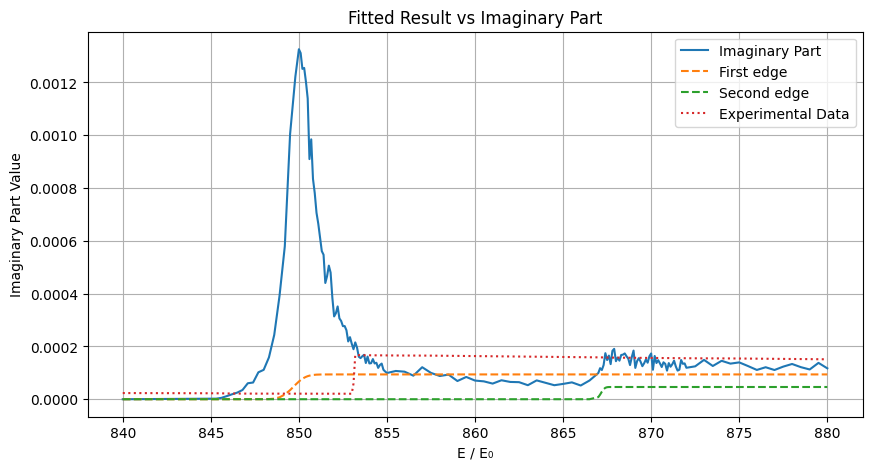

In [13]:
erf1_center = popt[0]
erf1_width = popt[1]
erf1_amp = popt[2]
erf2_center = popt[3]
erf2_width = popt[4]
erf2_amp = popt[5]

erf1 = erf1_amp * (1 + erf((df["energy"].values - erf1_center) / erf1_width)) / 2
erf2 = erf2_amp * (1 + erf((df["energy"].values - erf2_center) / erf2_width)) / 2
#  Scale the results so that at the start it matches with the n_i[0] and
# at the end it matches with n_i[-1] using a multiplicative factor and linear
# shift
# scale = (n_i[0] - n_i[-1]) / (result[0] - result[-1])
# shift = n_i[0] - scale * result[0]
# result = scale * result + shift

# scale = (result[0] - result[-1]) / (df["n_izz"].iloc[0] - df["n_izz"].iloc[-1])
# shift = result[0] - scale * df["n_izz"].iloc[0]
# df["n_i_scaled"] = scale * df["n_izz"] + shift

# Plot the final result
plt.figure(figsize=(10, 5))
plt.plot(df["energy"], df["n_izz"], label="Imaginary Part")
plt.plot(df["energy"], erf1, label="First edge", linestyle="--")
plt.plot(df["energy"], erf2, label="Second edge", linestyle="--")
plt.plot(df["energy"], n_i, label="Experimental Data", linestyle=":")
plt.title("Fitted Result vs Imaginary Part")
plt.xlabel("E / E₀")
plt.ylabel("Imaginary Part Value")
plt.legend()
plt.grid()
plt.show()

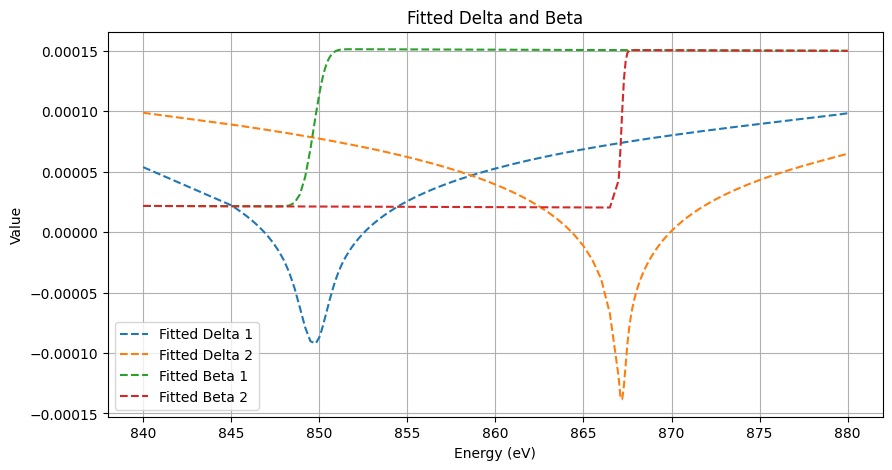

In [18]:
from kkcalc import kk

calc_real_part1 = kk.kk_calculate_real(
    np.column_stack((df["energy"].values, erf1)),
    "Ni",
    input_data_type="beta",
    load_options=None,
    merge_points=[df["energy"].min(), df["energy"].max()],
    add_background=False,
    curve_tolerance=0.01,
    curve_recursion=100,
)
calc_real_part2 = kk.kk_calculate_real(
    np.column_stack((df["energy"].values, erf2)),
    "Ni",
    input_data_type="beta",
    load_options=None,
    merge_points=[df["energy"].min(), df["energy"].max()],
    add_background=False,
    curve_tolerance=0.01,
    curve_recursion=100,
)
calc_real_part_data = kk.kk_calculate_real(
    np.column_stack((df["energy"].values, df["n_izz"].values)),
    "Ni",
    input_data_type="beta",
    load_options=None,
    merge_points=[df["energy"].min(), df["energy"].max()],
    add_background=False,
    curve_tolerance=0.01,
    curve_recursion=100,
)
stoichiometry = kk.data.ParseChemicalFormula("Ni")
mass = kk.data.calculate_FormulaMass(stoichiometry)

ip_delta1 = kk.data.convert_data(
    calc_real_part1[:, [0, 1]], "ASF", "refractive_index", Density=1, Formula_Mass=mass
)

ip_beta1 = kk.data.convert_data(
    calc_real_part1[:, [0, 2]], "ASF", "beta", Density=1, Formula_Mass=mass
)

ip_delta2 = kk.data.convert_data(
    calc_real_part2[:, [0, 1]], "ASF", "refractive_index", Density=1, Formula_Mass=mass
)

ip_beta2 = kk.data.convert_data(
    calc_real_part2[:, [0, 2]], "ASF", "beta", Density=1, Formula_Mass=mass
)

data_delta = kk.data.convert_data(
    calc_real_part_data[:, [0, 1]],
    "ASF",
    "refractive_index",
    Density=1,
    Formula_Mass=mass,
)

data_beta = kk.data.convert_data(
    calc_real_part_data[:, [0, 2]],
    "ASF",
    "beta",
    Density=1,
    Formula_Mass=mass,
)

fitted_delta1 = np.interp(df["energy"].values, ip_delta1[:, 0], ip_delta1[:, 1])
fitted_beta1 = np.interp(df["energy"].values, ip_beta1[:, 0], ip_beta1[:, 1])
delta_data_fitted = np.interp(df["energy"].values, data_delta[:, 0], data_delta[:, 1])
beta_data_fitted = np.interp(df["energy"].values, data_beta[:, 0], data_beta[:, 1])

fitted_delta2 = np.interp(df["energy"].values, ip_delta2[:, 0], ip_delta2[:, 1])
fitted_beta2 = np.interp(df["energy"].values, ip_beta2[:, 0], ip_beta2[:, 1])

#  Plot the results
plt.figure(figsize=(10, 5))
plt.plot(df["energy"], fitted_delta1, label="Fitted Delta 1", linestyle="--")
plt.plot(df["energy"], fitted_delta2, label="Fitted Delta 2", linestyle="--")
# plt.plot(df["energy"], delta_data_fitted1, label="Data Delta 1", linestyle=":")
plt.plot(df["energy"], fitted_beta1, label="Fitted Beta 1", linestyle="--")
plt.plot(df["energy"], fitted_beta2, label="Fitted Beta 2", linestyle="--")
# plt.plot(df["energy"], beta_data_fitted1, label="Data Beta 1", linestyle=":")
plt.title("Fitted Delta and Beta")
plt.xlabel("Energy (eV)")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

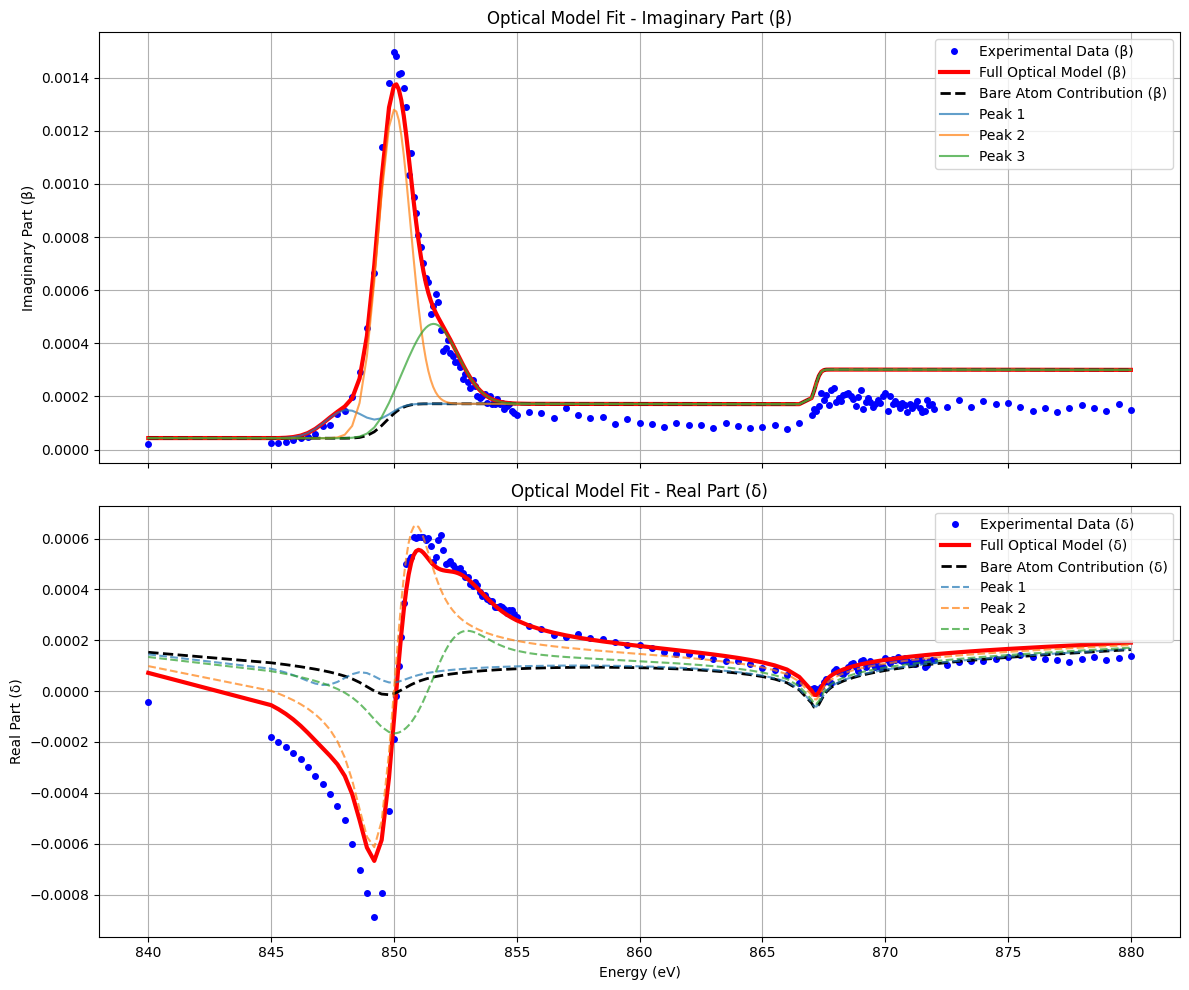

In [19]:
# The ionization potential is the bare atom contribution from the kkcalc
ionization_potential = (
    fitted_delta1 + 1j * fitted_beta1 + fitted_delta2 + 1j * fitted_beta2
)
# The full optical model starts with the bare atom contribution
optical_model = np.copy(ionization_potential)

# Create the figure and axes for plotting
fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Build the full optical model by adding resonant features ---
# This loop calculates the full model before plotting it
for i, (center, width, amplitude) in enumerate(fitted_peaks):
    feat = resonant_feature(df["energy"].values, center, width, amplitude)
    optical_model += feat

# --- Top Subplot: Imaginary Part (β) ---
ax2.set_title("Optical Model Fit - Imaginary Part (β)")
# Plot original experimental data
ax2.plot(
    df["energy"],
    beta_data_fitted,
    "o",
    label="Experimental Data (β)",
    color="blue",
    markersize=4,
)
# Plot the full fitted optical model
ax2.plot(
    df["energy"], optical_model.imag, label="Full Optical Model (β)", color="red", lw=3
)
# Plot the bare atom contribution (background)
ax2.plot(
    df["energy"],
    ionization_potential.imag,
    label="Bare Atom Contribution (β)",
    linestyle="--",
    color="k",
    lw=2,
)
# Plot individual resonant peaks that compose the model
for i, (center, width, amplitude) in enumerate(fitted_peaks):
    feat = resonant_feature(df["energy"].values, center, width, amplitude)
    ax2.plot(
        df["energy"].values,
        feat.imag + ionization_potential.imag,
        "-",
        alpha=0.7,
        label=f"Peak {i + 1}",
    )
ax2.set_ylabel("Imaginary Part (β)")
ax2.legend()
ax2.grid(True)

# --- Bottom Subplot: Real Part (δ) ---
ax1.set_title("Optical Model Fit - Real Part (δ)")
# Plot original experimental data
ax1.plot(
    df["energy"],
    delta_data_fitted,
    "o",
    label="Experimental Data (δ)",
    color="blue",
    markersize=4,
)
# Plot the full fitted optical model
ax1.plot(
    df["energy"], optical_model.real, label="Full Optical Model (δ)", color="red", lw=3
)
# Plot the bare atom contribution (background)
ax1.plot(
    df["energy"],
    ionization_potential.real,
    label="Bare Atom Contribution (δ)",
    linestyle="--",
    color="k",
    lw=2,
)
# Plot individual resonant peaks that compose the model
for i, (center, width, amplitude) in enumerate(fitted_peaks):
    feat = resonant_feature(df["energy"].values, center, width, amplitude)
    ax1.plot(
        df["energy"].values,
        feat.real + ionization_potential.real,
        "--",
        alpha=0.7,
        label=f"Peak {i + 1}",
    )
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel("Real Part (δ)")
ax1.legend()
ax1.grid(True)

# --- Final Touches ---
plt.tight_layout()
plt.show()

In [20]:
#  Save the steps
pd.DataFrame(ip_delta1, columns=["energy", "delta"]).to_csv(
    "ip_delta1.csv", index=False
)
pd.DataFrame(ip_beta1, columns=["energy", "beta"]).to_csv("ip_beta1.csv", index=False)
pd.DataFrame(ip_delta2, columns=["energy", "delta"]).to_csv(
    "ip_delta2.csv", index=False
)
pd.DataFrame(ip_beta2, columns=["energy", "beta"]).to_csv("ip_beta2.csv", index=False)
